# Testing Stock Fetcher 

## Imports 

In [111]:
# Reload Custom Modules 
import importlib
import src.beta_vae
import src.data_fetching 
import src.portfolio
importlib.reload(src.beta_vae)
importlib.reload(src.data_fetching)
importlib.reload(src.portfolio)

<module 'src.portfolio' from 'c:\\Users\\jairp\\OneDrive\\Desktop_remote\\HEC Montreal\\4. Fall 2024\\Deep Learning II\\Project\\StockDiversifier\\src\\portfolio.py'>

In [112]:
# General 
import os 
import json 
import numpy as np 
import pandas as pd

# General ML & Data Manipulation
import optuna 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# PyTorch
import torch

# Custom Classes 
from src.beta_vae import Encoder
from src.beta_vae import Decoder
from src.beta_vae import BetaVAE
from src.portfolio import Portfolio

# Custom Functions
from src.beta_vae import create_data_loaders
from src.beta_vae import create_single_data_loader
from src.beta_vae import objective
from src.beta_vae import train_beta_vae
from src.beta_vae import get_embeddings
from src.beta_vae import generate_embeddings_dict
from src.portfolio import fetch_and_calculate_returns
from src.data_fetching import scrape_sp500_wikipedia
from src.data_fetching import fetch_stock_data
from src.data_fetching import prepare_data_for_vae

## Fetching the data 

In [5]:
sp500_df = scrape_sp500_wikipedia()  # Scrape S&P 500 companies names, tikers and industris from Wikipedia
custom_tickers = ['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'TSLA', 'META', 'NVDA', 'PYPL', 'ADBE', 'NFLX']  # Example custom tickers
stock_data, sector_mapping, industry_mapping = fetch_stock_data(sp500_df, custom_tickers, 
                                                                period = "1y", interval = "1wk",
                                                                savepath="data_raw/stock_data.csv") # Fetch data
stock_data_vae = prepare_data_for_vae(stock_data)  # Prepare data for VAE

Fetching stock data...:  34%|███▍      | 172/502 [03:13<06:41,  1.22s/it]AMTM: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
AMTM: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
Fetching stock data...:  57%|█████▋    | 286/502 [05:26<04:40,  1.30s/it]$BF.B: possibly delisted; no price data found  (period=1y)
$BF.B: possibly delisted; no price data found  (period=1y)
Fetching stock data...:  77%|███████▋  | 387/502 [07:30<02:17,  1.20s/it]$BRK.B: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$BRK.B: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
Fetching stock data...:  99%|█████████▉| 499/502 [09:49<00:03,  1.15s/it]SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
Fetc

Completed fetching stock data in 592.53 seconds.
saving data to data_raw/stock_data.csv


In [33]:
stock_data.head()

,Ticker,Company Name,Market Cap,Sector,Industry,Open Price,Close Price,High Price,Low Price,Last Close,52 Week High,52 Week Low,Last Month Volatility,52 Week Volatility,Yearly Dividend Rate,Last Year Return Rate,Sector_encoded,Industry_encoded
0,GPC,Genuine Parts Company,1.735169e+10,Consumer Discretionary,Auto Parts,139.841634,139.384095,162.123691,112.739998,124.800003,162.123684,112.739998,0.308248,0.316231,4.00,-0.065929,0,0
1,CHD,"Church & Dwight Co., Inc.",2.741528e+10,Consumer Staples,Household & Personal Products,101.102982,101.480048,113.500000,89.270235,111.900002,113.500000,89.270235,0.154341,0.168622,1.14,0.193089,1,1
2,CAT,Caterpillar Inc.,1.919090e+11,Industrials,Farm & Heavy Construction Machinery,333.476794,336.026801,418.500000,237.992884,397.489990,418.500000,242.126563,0.253062,0.265249,5.64,0.632702,2,2
3,GD,General Dynamics Corporation,7.748901e+10,Industrials,Aerospace & Defense,280.483723,280.692393,316.899994,239.039237,281.809998,316.899994,239.039234,0.174318,0.175839,5.68,0.160090,2,3
4,KVUE,Kenvue Inc.,4.616762e+10,Consumer Staples,Household & Personal Products,20.090258,20.160055,24.309999,17.348562,24.080000,24.309999,17.348561,0.248528,0.276114,0.82,0.236623,1,1


In [8]:
# Display the data 
print(stock_data_vae.head())

     Market Cap  Open Price  Close Price  High Price   Low Price  Last Close  \
0  1.735169e+10  139.841634   139.384095  162.123691  112.739998  124.800003   
1  2.741528e+10  101.102982   101.480048  113.500000   89.270235  111.900002   
2  1.919090e+11  333.476794   336.026801  418.500000  237.992884  397.489990   
3  7.748901e+10  280.483723   280.692393  316.899994  239.039237  281.809998   
4  4.616762e+10   20.090258    20.160055   24.309999   17.348562   24.080000   

   52 Week High  52 Week Low  Last Month Volatility  52 Week Volatility  ...  \
0    162.123684   112.739998               0.308248            0.316231  ...   
1    113.500000    89.270235               0.154341            0.168622  ...   
2    418.500000   242.126563               0.253062            0.265249  ...   
3    316.899994   239.039234               0.174318            0.175839  ...   
4     24.309999    17.348561               0.248528            0.276114  ...   

   Industry_Tools & Accessories  Indus

In [18]:
# Print number of columns in total 
print(len(stock_data_vae.columns))

# Print total number of rows 
print(len(stock_data_vae))

# Print the data types of the columns
print(stock_data_vae.dtypes)

134
498
Market Cap                                 float64
Open Price                                 float64
Close Price                                float64
High Price                                 float64
Low Price                                  float64
                                            ...   
Industry_Utilities - Regulated Electric    float64
Industry_Utilities - Regulated Gas         float64
Industry_Utilities - Regulated Water       float64
Industry_Utilities - Renewable             float64
Industry_Waste Management                  float64
Length: 134, dtype: object


In [12]:
print(stock_data_vae.columns)

Index(['Market Cap', 'Open Price', 'Close Price', 'High Price', 'Low Price',
       'Last Close', '52 Week High', '52 Week Low', 'Last Month Volatility',
       '52 Week Volatility',
       ...
       'Industry_Tools & Accessories', 'Industry_Travel Services',
       'Industry_Trucking', 'Industry_Utilities - Diversified',
       'Industry_Utilities - Independent Power Producers',
       'Industry_Utilities - Regulated Electric',
       'Industry_Utilities - Regulated Gas',
       'Industry_Utilities - Regulated Water',
       'Industry_Utilities - Renewable', 'Industry_Waste Management'],
      dtype='object', length=134)


### Check for any NA's

In [13]:
# Check if any columns have nas
print(stock_data_vae.isna().sum().sum())

# Produce a list of columns with nas, and the amount for each 
print(stock_data_vae.columns[stock_data_vae.isna().any()].tolist())

# Calculate the proportion of nas in the stock_data_vae dataframe for each column with nas 
# only for the columns with nas
nas_proportion = stock_data_vae.isna().mean()
print(nas_proportion[stock_data_vae.columns[stock_data_vae.isna().any()].tolist()])

0
[]
Series([], dtype: float64)


## Fitting the $\beta$-VAE

### Data Preparation

In [14]:
# Normalize the stock data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(stock_data_vae)

# Convert the normalized data to PyTorch tensors
tensor_data = torch.tensor(normalized_data, dtype=torch.float32)

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(tensor_data)

# Check the DataLoader output
next(iter(train_loader))[0].shape  # Shape of one batch of data

torch.Size([64, 134])

### Hyperparameter Tunning

In [ ]:
# Define the file path for storing the best parameters
best_params_file = "config/best_params.json"

REWRITE = True 
if REWRITE:
    # Delete previous best_params file
    if os.path.exists(best_params_file):
        os.remove(best_params_file)

# Check if the best_params file exists
if os.path.exists(best_params_file):
    # Load the best parameters from the file
    with open(best_params_file, "r") as f:
        best_params = json.load(f)
    print("Loaded best parameters from file:", best_params)
    
else:
    # File doesn't exist, run the Optuna study
    print("Best parameters file not found. Running Optuna study...")
    
    # Assuming `normalized_data` is the prepared dataset
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, normalized_data), n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params
    print("Best hyperparameters found:", best_params)

    # Save the best parameters to a JSON file
    os.makedirs(os.path.dirname(best_params_file), exist_ok=True)  # Create directory if it doesn't exist
    with open(best_params_file, "w") as f:
        json.dump(best_params, f, indent=4)
    print(f"Best parameters saved to {best_params_file}")

### Model Training

In [16]:

# File path for the saved model
model_path = "models/beta_vae_with_metadata.pth"

RETRAIN = True
if RETRAIN:
    # Delete previous model file
    if os.path.exists(model_path):
        os.remove(model_path)

# Check if the model file exists
if os.path.exists(model_path):
    print(f"Model found at {model_path}. Loading the model...")

    # Load model state and metadata
    model_metadata = torch.load(model_path)

    # Recreate the model using the saved metadata
    beta_vae = BetaVAE(
        input_dim=model_metadata["input_dim"],
        latent_dim=model_metadata["latent_dim"],
        beta=model_metadata["beta"]
    )
    beta_vae.load_state_dict(model_metadata["model_state"])
    beta_vae.eval()  # Set the model to evaluation mode
    print("Model loaded successfully.")
else:
    print(f"Model not found at {model_path}. Training a new model...")

    # Assuming you use the best hyperparameters from Optuna
    latent_dim = best_params['latent_dim']
    beta = best_params['beta']
    learning_rate = best_params['learning_rate']
    batch_size = best_params['batch_size']
    input_dim = stock_data_vae.shape[1]

    # Recreate DataLoaders with the best batch size
    train_loader, val_loader, test_loader = create_data_loaders(tensor_data, batch_size=batch_size)

    # Initialize and train the model
    beta_vae = BetaVAE(input_dim=input_dim, latent_dim=latent_dim, beta=beta)
    train_beta_vae(beta_vae, train_loader, val_loader, num_epochs=50, learning_rate=learning_rate)

    # Save the trained model with metadata
    os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Ensure the directory exists
    model_metadata = {
        "model_state": beta_vae.state_dict(),
        "input_dim": input_dim,
        "latent_dim": latent_dim,
        "beta": beta
    }
    torch.save(model_metadata, model_path)
    print(f"Model trained and saved to {model_path}.")

Model not found at models/beta_vae_with_metadata.pth. Training a new model...
Epoch [1/50], Training Loss: 156.5069
Epoch [1/50], Validation Loss: 133.7886
Epoch [2/50], Training Loss: 137.8640
Epoch [2/50], Validation Loss: 128.8586
Epoch [3/50], Training Loss: 136.3802
Epoch [3/50], Validation Loss: 128.6325
Epoch [4/50], Training Loss: 136.3518
Epoch [4/50], Validation Loss: 128.5802
Epoch [5/50], Training Loss: 136.3535
Epoch [5/50], Validation Loss: 128.5835
Epoch [6/50], Training Loss: 136.3444
Epoch [6/50], Validation Loss: 128.5731
Epoch [7/50], Training Loss: 136.3340
Epoch [7/50], Validation Loss: 128.5637
Epoch [8/50], Training Loss: 136.3397
Epoch [8/50], Validation Loss: 128.5922
Epoch [9/50], Training Loss: 136.3321
Epoch [9/50], Validation Loss: 128.6126
Epoch [10/50], Training Loss: 136.3560
Epoch [10/50], Validation Loss: 128.6426
Epoch [11/50], Training Loss: 136.3129
Epoch [11/50], Validation Loss: 128.6005
Epoch [12/50], Training Loss: 136.3412
Epoch [12/50], Valida

### Extract Embeddings for Train/Val/Test Data 

In [19]:
# Extract embeddings for the training data
train_embeddings = get_embeddings(beta_vae, train_loader)

# Optionally, extract embeddings for validation and test data
val_embeddings = get_embeddings(beta_vae, val_loader)
test_embeddings = get_embeddings(beta_vae, test_loader)

print("Train Embeddings Shape:", train_embeddings.shape)  # Should be (num_samples, latent_dim)

Train Embeddings Shape: torch.Size([348, 10])


### Extract Embeddings from the Stock Data 

In [25]:
# Generate embeddings for the stock data
stock_embeddings = generate_embeddings_dict(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Display the embeddings for the first stock
print(f"Embeddings for the first stock ({stock_data['Ticker'].iloc[0]}):")
print(stock_embeddings[stock_data["Ticker"].iloc[0]])

Embeddings for the first stock (GPC):
[-0.5775809  -0.10377542 -1.655416    0.1304022  -1.8716902  -0.67270297
  1.2407281  -1.1858854  -0.08820377  1.3448488 ]


### Portfolio Object Tests

#### Initialization

In [90]:
# Example returns for three stocks (numpy arrays of simulated returns)
returns_dict = {
    "AAPL": np.random.normal(0.001, 0.02, 1000),  # Apple
    "GOOGL": np.random.normal(0.0012, 0.025, 1000),  # Google
    "MSFT": np.random.normal(0.0008, 0.015, 1000)   # Microsoft
}

# Example weights (optional)
weights = {
    "AAPL": 0.4,
    "GOOGL": 0.4,
    "MSFT": 0.2
}

# Frequency of returns
frequency = "daily"

# Initialize the Portfolio object
portfolio = Portfolio(returns_dict=returns_dict, frequency=frequency, weights=weights, risk_free=0.00)

#### Attributes

In [91]:
# Print the tickers in the portfolio
print("Tickers:", portfolio.tickers)

# Print the raw returns dictionary
print("Raw Returns:")
for ticker, returns in portfolio.raw_returns.items():
    print(f"{ticker}: {returns[:5]}...")  # Print first 5 returns for each ticker

# Print the covariance matrix
print("Covariance Matrix (Sigma):\n", portfolio.Sigma)

# Print the diagonal of the covariance matrix (sigmas)
print("Volatilities (sigmas):", portfolio.sigmas)

# Portfolio statistics
print("Portfolio Expected Return:", portfolio.portfolio_expected_return)
print("Portfolio Volatility:", portfolio.portfolio_volatility)
print("Portfolio Diversification Ratio:", portfolio.diversification_ratio)
print("Portfolio Sharpe Ratio:", portfolio.sharpe_ratio)

Tickers: ['AAPL', 'GOOGL', 'MSFT']
Raw Returns:
AAPL: [ 0.043437    0.00268659  0.00564645  0.00516269 -0.02121924]...
GOOGL: [ 0.00920047  0.01275269 -0.0283584   0.05358016  0.03366729]...
MSFT: [ 0.00722692 -0.01376076 -0.00425239  0.02813144  0.00731609]...
Covariance Matrix (Sigma):
 [[ 3.76310528e-04 -3.14454894e-05 -1.36163128e-06]
 [-3.14454894e-05  6.20888765e-04  9.05899145e-06]
 [-1.36163128e-06  9.05899145e-06  2.19474891e-04]]
Volatilities (sigmas): [0.01939872 0.02491764 0.01481468]
Portfolio Expected Return: 0.0015564597882511938
Portfolio Volatility: 0.012629327124569536
Portfolio Diversification Ratio: 1.6382094319625766
Portfolio Sharpe Ratio: 0.12324170344936289


#### Calling Methods 

In [92]:
# Get covariance matrix as a DataFrame
cov_matrix_df = portfolio.get_covariance_matrix()
print("Covariance Matrix DataFrame:\n", cov_matrix_df)

# Get expected returns and volatilities (sigmas) as dictionaries
expected_returns, sigmas = portfolio.get_expected_returns_and_sigmas()
print("Expected Returns:", expected_returns)
print("Volatilities (sigmas):", sigmas)

# Get initial weights
init_weights = portfolio.get_weights()

# Optimize weights for maximum diversification
optimized_weights = portfolio.optimize_weights(method="max_div", update_weights=False)

# Update weights in the portfolio object after optimization
portfolio.optimize_weights(method="max_div", update_weights=True)

# Show weights before and after optimization 
print("Initial Weights:", init_weights)
print("Updated Weights:", portfolio.get_weights())

# Updated portfolio statistics after optimization
print("Updated Portfolio Expected Return:", portfolio.portfolio_expected_return)
print("Updated Portfolio Volatility:", portfolio.portfolio_volatility)
print("Updated Portfolio Diversification Ratio:", portfolio.diversification_ratio)
print("Updated Portfolio Sharpe Ratio:", portfolio.sharpe_ratio)

Covariance Matrix DataFrame:
            AAPL     GOOGL      MSFT
AAPL   0.000376 -0.000031 -0.000001
GOOGL -0.000031  0.000621  0.000009
MSFT  -0.000001  0.000009  0.000219
Expected Returns: {'AAPL': 0.0013968448242321527, 'GOOGL': 0.0022223978259293792, 'MSFT': 0.0005438136409329037}
Volatilities (sigmas): {'AAPL': 0.019398724917969762, 'GOOGL': 0.024917639637161308, 'MSFT': 0.014814684963790955}
Initial Weights: {'AAPL': 0.4, 'GOOGL': 0.4, 'MSFT': 0.2}
Updated Weights: {'AAPL': 0.33847891116114504, 'GOOGL': 0.2568790568030856, 'MSFT': 0.40464203203576943}
Updated Portfolio Expected Return: 0.0012637398292490074
Updated Portfolio Volatility: 0.01077317989117982
Updated Portfolio Diversification Ratio: 1.7600674522426196
Updated Portfolio Sharpe Ratio: 0.1173042538984847


#### Copying and updating the portfolio

In [93]:
# Example returns for additional stocks
returns_dict_new = {
    "AMZN": np.random.normal(0.0015, 0.03, 1000),  # Amazon
    "TSLA": np.random.normal(0.002, 0.05, 1000)   # Tesla
}

# Copy the existing portfolio
copied_portfolio = portfolio.copy_portfolio()
print("\n--- Copied Portfolio ---")
print("Tickers in copied portfolio:", copied_portfolio.tickers)
print("Weights in copied portfolio:", copied_portfolio.get_weights())
print("Expected Return (Copied):", copied_portfolio.portfolio_expected_return)
print("Volatility (Copied):", copied_portfolio.portfolio_volatility)
print("Diversification Ratio (Copied):", copied_portfolio.diversification_ratio)
print("Sharpe Ratio (Copied):", copied_portfolio.sharpe_ratio)

# Update portfolio: Add new tickers and remove an existing ticker
add_tickers = {"AMZN": returns_dict_new["AMZN"], "TSLA": returns_dict_new["TSLA"]}
remove_tickers = ["MSFT"]
new_weights = {"AAPL": 0.3, "GOOGL": 0.3, "AMZN": 0.2, "TSLA": 0.2}

# Update the portfolio 
portfolio.update_portfolio(add_tickers=add_tickers, remove_tickers=remove_tickers, new_weights=new_weights)

# Print updated portfolio attributes
print("\n--- Updated Portfolio ---")
print("Updated Tickers:", portfolio.tickers)
print("Updated Weights:", portfolio.get_weights())

# Portfolio statistics after update
print("Updated Portfolio Expected Return:", portfolio.portfolio_expected_return)
print("Updated Portfolio Volatility:", portfolio.portfolio_volatility)
print("Updated Portfolio Diversification Ratio:", portfolio.diversification_ratio)
print("Updated Portfolio Sharpe Ratio:", portfolio.sharpe_ratio)

# Optimize updated portfolio weights and compare again 
print("\n--- Optimization After Update ---")
portfolio.optimize_weights(method="max_div", update_weights=True)

# Updated portfolio statistics after optimization
print("Updated Tickers:", portfolio.tickers)
print("Updated Weights:", portfolio.get_weights())
print("Updated Portfolio Expected Return:", portfolio.portfolio_expected_return)
print("Updated Portfolio Volatility:", portfolio.portfolio_volatility)
print("Updated Portfolio Diversification Ratio:", portfolio.diversification_ratio)
print("Updated Portfolio Sharpe Ratio:", portfolio.sharpe_ratio)


--- Copied Portfolio ---
Tickers in copied portfolio: ['AAPL', 'GOOGL', 'MSFT']
Weights in copied portfolio: {'AAPL': 0.33847891116114504, 'GOOGL': 0.2568790568030856, 'MSFT': 0.40464203203576943}
Expected Return (Copied): 0.0012637398292490074
Volatility (Copied): 0.01077317989117982
Diversification Ratio (Copied): 1.7600674522426196
Sharpe Ratio (Copied): 0.1173042538984847

--- Updated Portfolio ---
Updated Tickers: ['AAPL', 'GOOGL', 'AMZN', 'TSLA']
Updated Weights: {'AAPL': 0.3, 'GOOGL': 0.3, 'AMZN': 0.2, 'TSLA': 0.2}
Updated Portfolio Expected Return: 0.0018268702722948173
Updated Portfolio Volatility: 0.014330722677749866
Updated Portfolio Diversification Ratio: 2.0182068788800334
Updated Portfolio Sharpe Ratio: 0.1173042538984847

--- Optimization After Update ---
Updated Tickers: ['AAPL', 'GOOGL', 'AMZN', 'TSLA']
Updated Weights: {'AAPL': 0.360392364798825, 'GOOGL': 0.2797946710838996, 'AMZN': 0.22366153130904817, 'TSLA': 0.13615143280822717}
Updated Portfolio Expected Return:

### Fetching Returns-Only Data For All Stocks

In [41]:
# Fetch and calculate returns for the all tickers in the S&P 500 and additional tickers
all_tickers = stock_data["Ticker"].values.tolist()  # All S&P 500 tickers
print(len(all_tickers))
print(all_tickers[:5])

# Fetch and calculate returns for all tickers
all_returns = fetch_and_calculate_returns(all_tickers, period="1y", interval="1wk", price_column="Close")


498
['GPC', 'CHD', 'CAT', 'GD', 'KVUE']


Fetching Data: 100%|██████████| 498/498 [02:28<00:00,  3.36ticker/s]


In [94]:
# Show one example return series
print("Returns for AAPL:")
print(all_returns["AAPL"])

Returns for AAPL:
[ 0.00668535  0.02337363  0.00950388 -0.02009403 -0.00552697 -0.05895191
  0.02616181  0.03033579  0.00448936 -0.03414395  0.01614201 -0.03339895
  0.00115197 -0.0156695  -0.04970504  0.01107007 -0.00196956 -0.00464362
 -0.01107997  0.04110154 -0.06542058  0.02606062  0.08316588 -0.00179947
  0.0386644   0.00057937  0.01194859  0.02413527  0.07923211 -0.02353049
  0.01508496  0.0746368   0.01855617 -0.02702351 -0.02830899  0.00871721
 -0.01646498  0.04536618  0.00465631  0.00952219 -0.0357205   0.00760797
  0.02561793 -0.00179665 -0.00434609  0.00330688  0.03274001 -0.01527655
 -0.03673136  0.01816883 -0.00754524  0.02164442]


### Building the Recommendation Function 

Portfolio Summary:
Tickers: ['ORCL', 'WEC', 'OXY', 'CTVA', 'PYPL', 'ROL', 'SWK', 'ZBRA', 'ADM', 'TMUS', 'MMM', 'MO', 'CTRA', 'DOC', 'KMX', 'ACGL', 'TGT', 'CMS', 'MSFT', 'STX']
Weights: {'ORCL': 0.05, 'WEC': 0.05, 'OXY': 0.05, 'CTVA': 0.05, 'PYPL': 0.05, 'ROL': 0.05, 'SWK': 0.05, 'ZBRA': 0.05, 'ADM': 0.05, 'TMUS': 0.05, 'MMM': 0.05, 'MO': 0.05, 'CTRA': 0.05, 'DOC': 0.05, 'KMX': 0.05, 'ACGL': 0.05, 'TGT': 0.05, 'CMS': 0.05, 'MSFT': 0.05, 'STX': 0.05}
Portfolio Expected Return: 0.005182431002027229
Portfolio Volatility: 0.015563503454339548
Portfolio Diversification Ratio: 2.305638169440058
Portfolio Sharpe Ratio: 0.3329861439766134


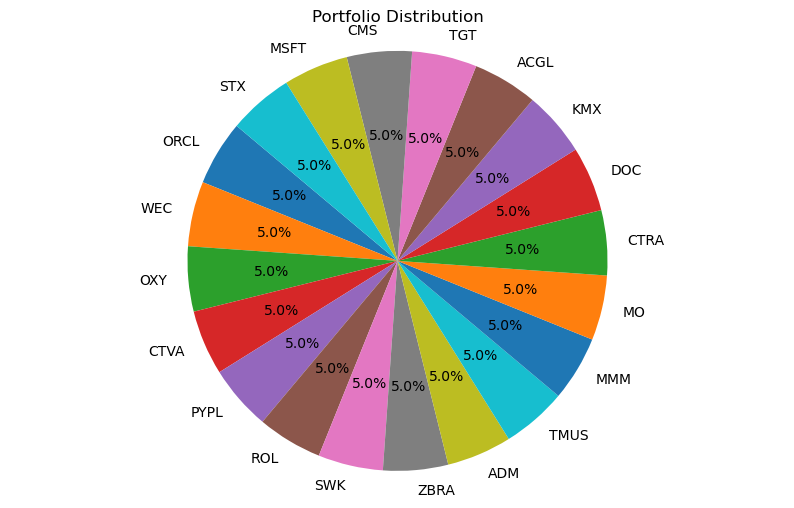

In [113]:
# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 20, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Obtain a summary of the portfolio 
random_portfolio.summarize_portfolio()

# Visualize portfolio distribution 
random_portfolio.visualize_portfolio_distribution()



--- Portfolio Summary After Optimization ---
Portfolio Summary:
Tickers: ['ORCL', 'WEC', 'OXY', 'CTVA', 'PYPL', 'ROL', 'SWK', 'ZBRA', 'ADM', 'TMUS', 'MMM', 'MO', 'CTRA', 'DOC', 'KMX', 'ACGL', 'TGT', 'CMS', 'MSFT', 'STX']
Weights: {'ORCL': 0.00754545865797311, 'WEC': 1.9540430800757833e-17, 'OXY': 0.15418236768014174, 'CTVA': 0.0003475568408828117, 'PYPL': 5.267234520420417e-17, 'ROL': 1.1854449375532467e-17, 'SWK': 0.0, 'ZBRA': 4.83943335210088e-16, 'ADM': 0.003789022294009285, 'TMUS': 0.16384862774017545, 'MMM': 0.05970890087296331, 'MO': 0.16610237660033184, 'CTRA': 0.0, 'DOC': 0.0, 'KMX': 0.0, 'ACGL': 0.0, 'TGT': 0.04760537848708813, 'CMS': 0.1612368348780498, 'MSFT': 0.20753729203375307, 'STX': 0.028096183914639507}
Portfolio Expected Return: 0.004757381653321498
Portfolio Volatility: 0.00959719939556063
Portfolio Diversification Ratio: 3.0173504977454857
Portfolio Sharpe Ratio: 0.4957052007820237


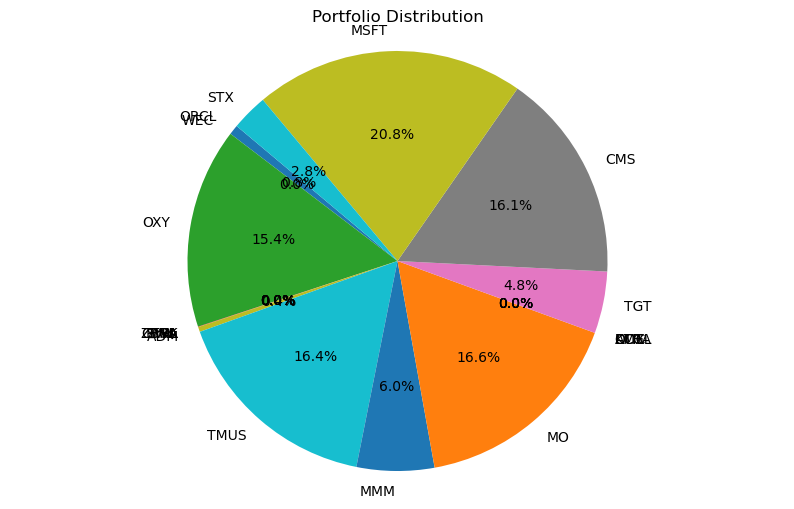

In [115]:
# Optimize portfolio weights 
random_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the portfolio after optimization
print("\n--- Portfolio Summary After Optimization ---")
random_portfolio.summarize_portfolio()

# Visualize the portfolio distribution after optimization
random_portfolio.visualize_portfolio_distribution()